
_This supervised learning model will predict good loans versus the bad loans.  The good loans are loan_status = Fully Paid. The bad loans are the loans with a 'loan_status' = Charged Off, Late (31-120 days) and Default.

# Tuning RFC and XGB
 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import timeit
import time

import warnings
warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['good_loan_status']
X = df.drop(['good_loan_status'], axis=1)

In [31]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((58654, 68), (58654,), (14664, 68), (14664,))

___I will run PCA to reduce the Dimensionality___

In [33]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [34]:
pca = PCA(n_components=None)
pcaFit = pca.fit(X_train_sc)

In [35]:
pca.explained_variance_ratio_

array([1.60838088e-01, 8.45346191e-02, 6.98641844e-02, 5.90085821e-02,
       4.11784743e-02, 3.33572398e-02, 3.16858191e-02, 2.99120464e-02,
       2.82681853e-02, 2.35638928e-02, 2.12525216e-02, 1.97100077e-02,
       1.89658135e-02, 1.82714980e-02, 1.75132120e-02, 1.63356060e-02,
       1.55302600e-02, 1.54740567e-02, 1.52354616e-02, 1.50131015e-02,
       1.45866644e-02, 1.40759996e-02, 1.35935908e-02, 1.29845908e-02,
       1.26015072e-02, 1.24732945e-02, 1.21896487e-02, 1.16675313e-02,
       1.13990083e-02, 1.07865348e-02, 1.04519978e-02, 9.74792226e-03,
       9.47225259e-03, 8.80789997e-03, 8.14246196e-03, 8.02749543e-03,
       7.54715229e-03, 7.32542662e-03, 7.24209787e-03, 6.83852255e-03,
       6.37221953e-03, 6.17201279e-03, 5.82513963e-03, 5.40898964e-03,
       5.03939848e-03, 4.35421512e-03, 4.21608443e-03, 3.79317409e-03,
       3.39849616e-03, 2.31099063e-03, 1.84772887e-03, 1.43844904e-03,
       1.05300946e-03, 8.26852134e-04, 5.19683830e-04, 4.44245796e-04,
      

In [41]:
np.cumsum(pca.explained_variance_ratio_)

array([0.16083809, 0.24537271, 0.31523689, 0.37424547, 0.41542395,
       0.44878119, 0.48046701, 0.51037905, 0.53864724, 0.56221113,
       0.58346365, 0.60317366, 0.62213947, 0.64041097, 0.65792418,
       0.67425979, 0.68979005, 0.70526411, 0.72049957, 0.73551267,
       0.75009933, 0.76417533, 0.77776892, 0.79075352, 0.80335502,
       0.81582832, 0.82801797, 0.8396855 , 0.85108451, 0.86187104,
       0.87232304, 0.88207096, 0.89154321, 0.90035111, 0.90849357,
       0.91652107, 0.92406822, 0.93139365, 0.93863575, 0.94547427,
       0.95184649, 0.9580185 , 0.96384364, 0.96925263, 0.97429203,
       0.97864624, 0.98286233, 0.9866555 , 0.990054  , 0.99236499,
       0.99421272, 0.99565117, 0.99670418, 0.99753103, 0.99805071,
       0.99849496, 0.99887695, 0.99925739, 0.99950766, 0.99971036,
       0.99987985, 0.99996631, 0.99997873, 0.99998712, 0.99999518,
       1.        , 1.        , 1.        ])

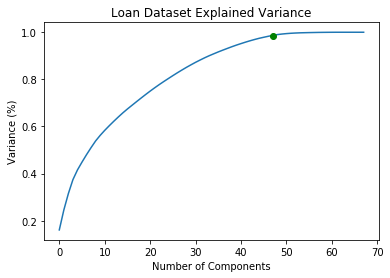

In [40]:
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(47, 0.98286233, 'go')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Loan Dataset Explained Variance')
plt.show()

_47 components are able to explain up to 98.286233% variance of the data._

In [14]:
# now limit to 47 components from 69, which should be around 98% hopefully
# pipeline = Pipeline(['scaling',StandardScaler()),'pca',PCA(n_components=35)])
# X_train_sc_pca=pipeline.fit_transform(X_train)
#X_test_sc_pca = pipeline.fit(X_test)

pca = PCA(n_components=47)
pcaFit = pca.fit(X_train_sc)  # get eigens

X_train_sc_pca = pca.fit_transform(X_train_sc)  # apply the eigens
X_test_sc_pca = pca.transform(X_test_sc)

In [15]:
X_train_sc_pca.shape, X_test_sc_pca.shape, y_train.shape, y_test.shape

((58654, 47), (14664, 47), (58654,), (14664,))

# Random Forest tuning
I am tuning the following features and I will apply adaboost to the tuned model. The model will run a 3 fold cross validation.

    - 'max_depth'
    - 'min_samples_leaf'
    - 'n_estimators'
    - 'max_features'
    - 'min_samples_split'

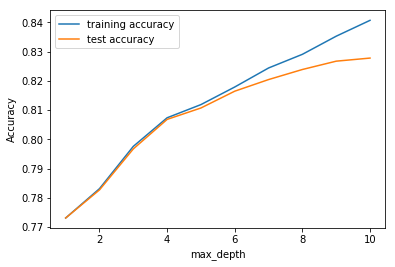

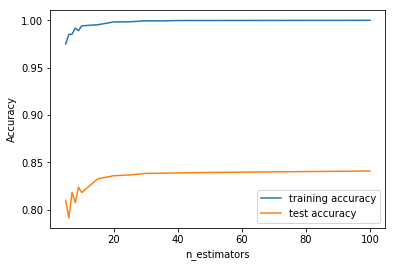

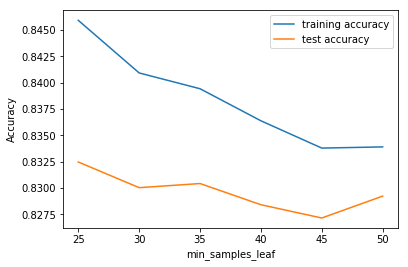

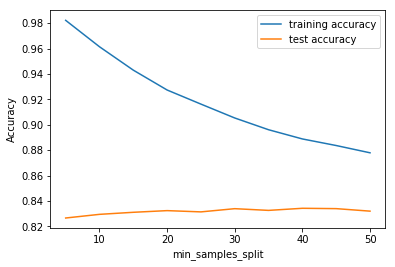

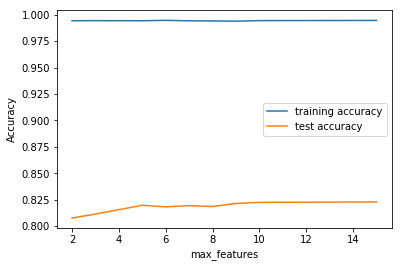

--- 710.4661 seconds --- 


In [16]:
# parameters to build the model on

start_time = time.time()

hyperparameter = ['max_depth',
                  'n_estimators',
                  'min_samples_leaf',
                  'min_samples_split',
                  'max_features']

range = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 50,100],
    [25, 30, 35, 40, 45, 50],
    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    [2, 3, 5, 6, 7, 8, 9, 10, 15]
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    rf = RandomForestClassifier()

    # fit tree on training data
    rfgrid = GridSearchCV(rf, parameters,
                          cv=3,
                          scoring="accuracy")
    rfgrid.fit(X_train_sc_pca, y_train)
    scores = rfgrid.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___Using the parameters above to fine tune to find the best model___

In [19]:
# Create the parameter grid based on the results of random search

param_grid = {
    'max_depth': [4, 6, 10],
    'min_samples_leaf': [30, 60, 70],
    'min_samples_split': [50, 60, 70],
    'n_estimators': [20, 40, 60],
    'max_features': [10, 30, 45]
}
# Create a based model
rf_tree = RandomForestClassifier()
# Instantiate the grid search model
rfgrid_search = GridSearchCV(estimator=rf_tree,
                             param_grid=param_grid,
                             cv=3, n_jobs=-1, verbose=1)

In [20]:
# Fit the grid search to the data
start_time = time.time()
rfgrid_search.fit(X_train_sc_pca, y_train)

stop = timeit.default_timer()
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 60.7min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 131.8min finished


--- 7953.0392 seconds --- 


In [21]:
# printing the optimal accuracy score and hyperparameters
print('The best RFC accuracy score is {0:.4f}'.format(
    rfgrid_search.best_score_),
    'and has the parameters\n', rfgrid_search.best_params_)

The best RFC accuracy score is 0.8395 and has the parameters
 {'max_depth': 10, 'max_features': 45, 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 20}


In [23]:
# model with the best hyperparameters
rf_final = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=30,
                                  min_samples_split=60,
                                  max_features=45,
                                  n_estimators=20)

_Tuned RFC has an accuracy score of ___83.95%___ and has the parameters:_

    max_depth=10
    min_samples_leaf=30
    min_samples_split=60
    max_features=10
    n_estimators=60
 

In [ ]:

pred = cross_val_predict(rf_final,x,y,cv=3)
residual = y_train - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Multicollinearity')
sns.heatmap(x.corr(), vmin = -1,square=True, cmap="PiYG")
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

-----

# Applying the AdaBoostClassifier to Random Forest

In [24]:
# adaboost with the RF tree as base estimator
start_time = time.time()
estimators = np.arange(1,15, 1)

ada_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(base_estimator=rf_final,
                             n_estimators=n_est)

    res = cross_val_score(ABC,
                          X_train_sc_pca,
                          y_train, cv=3)

    print("\nThe average accuracy score: {0:.4f}".format(np.mean(res)), n_est)
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))


The average accuracy score: 0.8384 1

The average accuracy score: 0.8469 2

The average accuracy score: 0.8511 3

The average accuracy score: 0.8531 4

The average accuracy score: 0.8558 5

The average accuracy score: 0.8549 6

The average accuracy score: 0.8556 7

The average accuracy score: 0.8573 8

The average accuracy score: 0.8574 9

The average accuracy score: 0.8579 10

The average accuracy score: 0.8574 11

The average accuracy score: 0.8570 12

The average accuracy score: 0.8582 13

The average accuracy score: 0.8578 14
--- 8009.4268 seconds --- 


_With ADAboost RaandomForest (n_estimator = 13) has an accuracy score: ___85.82%___, this is a ___1.87%___ improvement from the RFC model score of ___83.95%___.

------ 

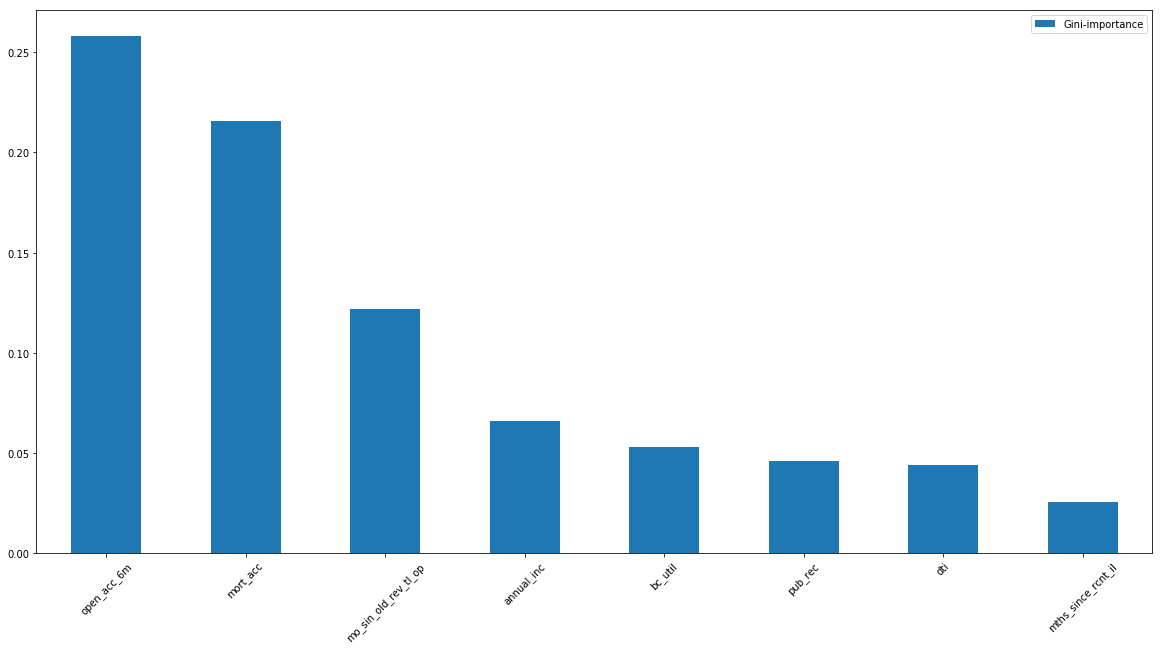

In [27]:
feats = {}  # a dict to hold feature_name: feature_importance
rf_final.fit(X_train_sc_pca, y_train)
for feature, importance in zip(X.columns, rf_final.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',
                        ascending=False).head(8).plot(kind='bar',
                                                      rot=45,
                                                      figsize=(20, 10))

_Feature importance of the boosted Random Forest.  Past medical expenses and open accounts are big factors in getting approved for a loan._

-------------

# Extreme Gradiant Boosting Tuning

I am tuning the following features to get the best score
    - 'max_depth'
    - 'learning_rate'
    - 'n_estimators'
    - 'subsample'
    - 'colsample_bytree'
    - 'colsample_bylevel'

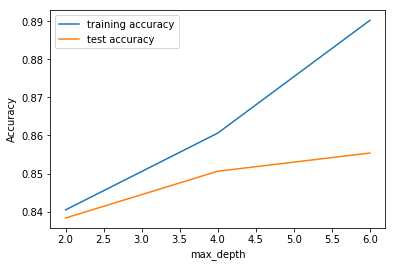

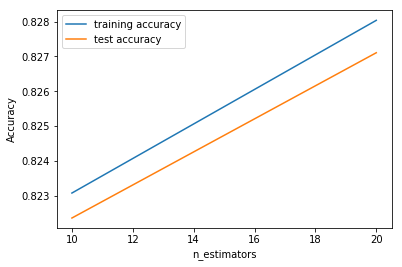

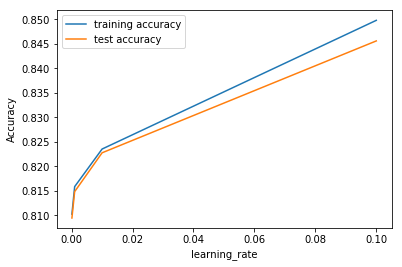

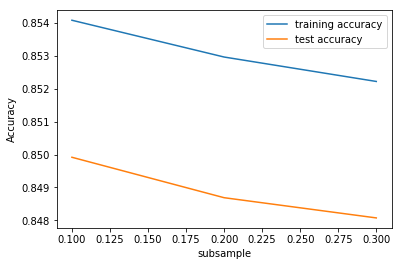

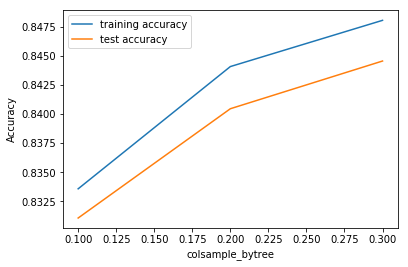

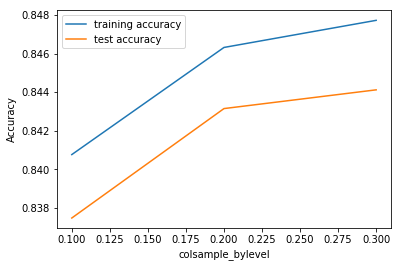

--- 774.8780 seconds --- 


In [28]:
start_time = time.time()


# parameters to build the model on
hyperparameter = ['max_depth', 'n_estimators', 'learning_rate',
                  'subsample', 'colsample_bytree', 'colsample_bylevel']

range = [
    [2, 4, 6],
    [10, 20],
    [0.0001, 0.001, 0.01, 0.1],
    [0.1, 0.2, 0.3],
    [0.1, 0.2, 0.3],
    [0.1, 0.2, 0.3],
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    XGB = XGBClassifier()

    # fit tree on training data
    XGB = GridSearchCV(XGB, parameters,
                       cv=3,
                       scoring="accuracy")  # you can change scoring functions right here.
    XGB.fit(X_train_sc_pca, y_train)
    scores = XGB.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___now let's plug in the values to get the final parameters___

In [42]:
param_grid = {
    'max_depth': [1, 2, 3,5,8],
    'n_estimators': [1, 10, 20, 30],
    'learning_rate': [0.0001,0.001, 0.01,0.1],
    'subsample': [0.0001, 0.1, 0.15, 0.2],
    'colsample_bytree': [0.01,0.1,0.2],
    'colsample_bylevel': [0.0001, 0.001, 0.01], }
# Create a based model
xgb = XGBClassifier()
# Instantiate the grid search model
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                        cv=3, n_jobs=-1, verbose=1)

In [43]:
# Fit the grid search to the data
start_time = time.time()
xgb_grid.fit(X_train_sc_pca, y_train)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 55.7min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 67.0min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 68.9min finished


--- 4134.7073 seconds --- 


In [44]:
# printing the optimal accuracy score and hyperparameters
print('The best XGB accuracy score is {0:.4f}'.format(
    xgb_grid.best_score_), 'with parameters\n', xgb_grid.best_params_)

The best XGB accuracy score is 0.8007 with parameters
 {'colsample_bylevel': 0.0001, 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 30, 'subsample': 0.2}


In [45]:
xgb_param_grid = {
    'max_depth': [8],
    'n_estimators': [30],
    'learning_rate': [0.1],
    'subsample': [0.2],
    'colsample_bytree': [0.2],
    'colsample_bylevel': [0.0001]}
xgb_final = XGBClassifier()

xgb_grid_f = GridSearchCV(estimator=xgb_final, param_grid=xgb_param_grid,
                          cv=3, n_jobs=-1, verbose=1)
xgb_grid_f.fit(X_train_sc_pca, y_train)
print('We can get accuracy of {0:.4f}'.format(
    xgb_grid_f.best_score_), 'with parameters\n', xgb_grid_f.best_params_)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


We can get accuracy of 0.8007 with parameters
 {'colsample_bylevel': 0.0001, 'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 30, 'subsample': 0.2}
--- 4208.6684 seconds --- 


_The accuracy score for Extreme Gradient Boost:_ ___80.07%___

In [46]:
xgb.fit(X_train_sc_pca, y_train)
xgb_fea_imp = pd.DataFrame(list(xgb.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)
print('', xgb_fea_imp)

    feature  importance
1      f29          88
2      f26          80
0      f11          62
8      f24          57
4       f2          54
6       f3          52
5       f6          44
9       f4          43
3      f14          36
10      f5          32
12     f30          20
14     f23          19
11      f7          18
15     f10          14
13      f8          10
23     f34           9
19     f20           8
22      f0           7
21     f25           6
29     f22           6
31      f1           5
18      f9           5
28     f12           4
17     f17           3
16     f15           3
24     f37           2
25     f35           2
7      f18           2
34     f13           2
20     f32           1
26     f27           1
27     f16           1
30     f40           1
32     f39           1
33     f36           1
35     f46           1


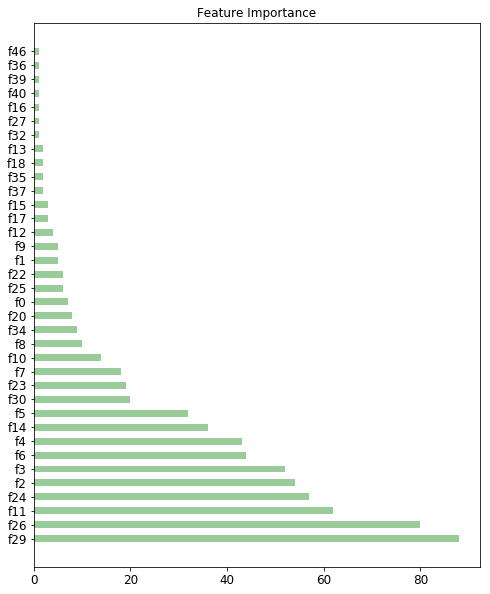

In [47]:
index = np.arange(len(xgb_fea_imp))
fig = plt.figure(figsize=(8, 10))
plt.subplot('111')
bar_width = 0.5
plt.xticks(size=12)
plt.yticks(size=12)
rects = plt.barh(index, xgb_fea_imp["importance"],
                 bar_width, alpha=0.4, color='g', label='Main')
plt.title('Feature Importance')
plt.yticks(index, xgb_fea_imp["feature"])

plt.show()

-----

# Gradient Boosting Tuning

I am tuning the following features to get the best score
  
    - 'max_features' :features
    - 'max_leaf_nodes' :num of nodes/leaves
    - 'max_depth' :depth of trees
    - 'min_samples_split' :min num of samples in a node
    - 'min_samples_leaf' :samples in a node/leaf

In [ ]:
# Fit the grid search to the data
start_time = time.time()

parameters = {
    "n_estimators": [5, 50, 250, 500],
    "max_depth": [1, 3, 5],
    "learning_rate": [1e-06, 1e-05, 0.01, 0.1]
}
abc_scores = []
for n_est in estimators:
    GBC = GradientBoostingClassifier(n_estimators=n_est)

    ABC.fit(X_train_sc_pca, y_train)
    y_pred = ABC.predict(X_test_sc_pca)
    score = metrics.accuracy_score(y_test, y_pred)
    abc_scores.append(score)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

In [ ]:
# plot test scores and n_estimators
plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.85, 1])
plt.show()

In [ ]:
# specify number of folds for k-fold CV
start_time = time.time()


# parameters to build the model on
parameters = {'n_estimators': [5, 10, 20]}
# instantiate the model
dtree = AdaBoostClassifier()

# fit tree on training data
tree = GridSearchCV(dtree, parameters,
                    cv=3,
                    scoring="accuracy")
tree.fit(X_train_sc_pca, y_train)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_

In [ ]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"],
         scores["mean_train_score"],
         label="training accuracy")
plt.plot(scores["param_n_estimators"],
         scores["mean_test_score"],
         label="test accuracy")
plt.xlabel("n_estimatorss")
plt.ylabel("Accuracy")
plt.legend()
plt.show()